In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D, Layer, Lambda, BatchNormalization, GlobalAveragePooling2D

In [ ]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model

        :param X: numpy.ndarray of shape (m, 32, 32, 3)
            containing the CIFAR 10 data, where m is the
            number of data points

        :param Y: numpy.ndarray of shape (m,) containing
            the CIFAR 10 labels for X

        :returns: X_p, Y_p
    """
    X_p = K.applications.densenet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
CALLBACKS = []
MODEL_PATH = '/content/drive/MyDrive/Cifar/Main/model'
optimizer = K.optimizers.Adam()

# load cifar 10
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


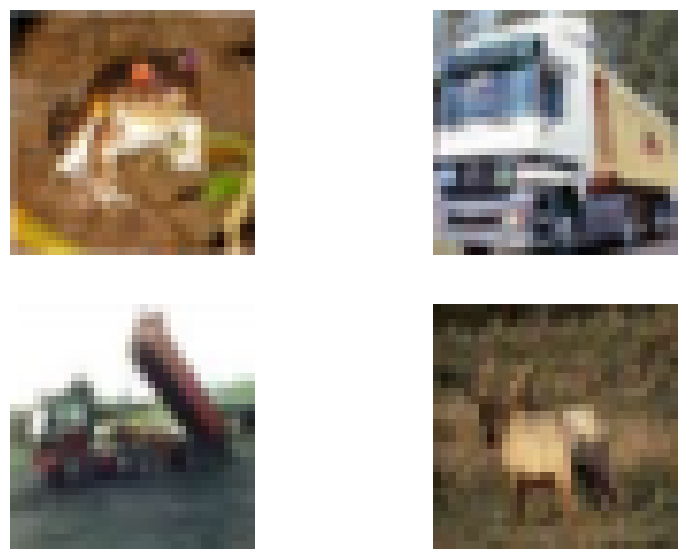

In [ ]:
plt.figure(figsize = (10,7))
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(x_train[0])
ax1.axis('off')

# add a subplot with no frame
ax2 = plt.subplot(222, frameon=False)
ax2.imshow(x_train[1])
ax2.axis('off')

# add a polar subplot
ax3 = plt.subplot(223)
ax3.imshow(x_train[2])
ax3.axis('off')

# add a red subplot that shares the x-axis with ax1
ax4 = plt.subplot(224)
ax4.imshow(x_train[3])
ax4.axis('off')
plt.show()

In [ ]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# input tensor
inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 160, 160,
                                                             method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
base_model = K.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3))

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
# add top layers
out = base_model.output
out = Flatten()(out)
out = BatchNormalization()(out)
out = Dense(124, activation='relu')(out)
out = Dropout(0.7)(out)
out = BatchNormalization()(out)
out = Dense(64, activation='relu')(out)
out = Dropout(0.4)(out)
out = Dense(10, activation='softmax')(out)

In [ ]:
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))
CALLBACKS.append(K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=2, verbose=1))

# CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))
# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_test, y_test))

Epoch 1/20
391/391 [==============================] - 436s 910ms/step - loss: 0.9839 - accuracy: 0.6883 - val_loss: 0.7481 - val_accuracy: 0.7813 - lr: 0.0010
Epoch 2/20
391/391 [==============================] - 343s 878ms/step - loss: 0.5103 - accuracy: 0.8536 - val_loss: 0.5210 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 3/20
391/391 [==============================] - 338s 865ms/step - loss: 0.4034 - accuracy: 0.8850 - val_loss: 0.4723 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 4/20
391/391 [==============================] - 345s 881ms/step - loss: 0.3262 - accuracy: 0.9067 - val_loss: 0.3708 - val_accuracy: 0.8874 - lr: 0.0010
Epoch 5/20
391/391 [==============================] - 286s 732ms/step - loss: 0.2897 - accuracy: 0.9173 - val_loss: 0.4053 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 6/20
391/391 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9266
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
391/391 [=======================

In [ ]:
model.evaluate(x_test, y_test, batch_size=128, verbose=1)

79/79 [==============================] - 14s 180ms/step - loss: 0.1702 - accuracy: 0.9561


[0.1702033281326294, 0.9560999870300293]

In [ ]:
model.save('/content/drive/MyDrive/Cifar/Main/main_Cifar10.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications.densenet import decode_predictions

In [ ]:
# Load the pre-trained VGG16 model
model_path = '/content/drive/MyDrive/Cifar/Main/main_Cifar10.h5'
model = load_model(model_path)

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
def custom_cifar10_prediction(image_path):
    try:
        # Load and preprocess the user-provided image
        image = load_img(image_path, target_size=(32, 32))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        # Make predictions using the model
        predictions = model.predict(image)

        # Convert the predicted class index to class name
        class_index = np.argmax(predictions)
        class_name = cifar10_classes[class_index]  # You need to define cifar10_classes

        # Display the image
        plt.imshow(image[0] / 2 + 0.5)  # De-normalize the image
        plt.axis('off')
        plt.title(f"Predicted class: {class_name}")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [ ]:
# Define the CIFAR-10 class names (you can define this based on your model)
cifar10_classes = [
    'Airplane',
    'Automobile',
    'Bird',
    'Cat',
    'Deer',
    'Dog',
    'Frog',
    'Horse',
    'Ship',
    'Truck'
]

1/1 [==============================] - 0s 50ms/step


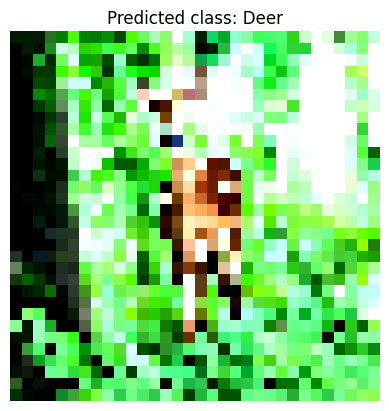

1/1 [==============================] - 0s 123ms/step


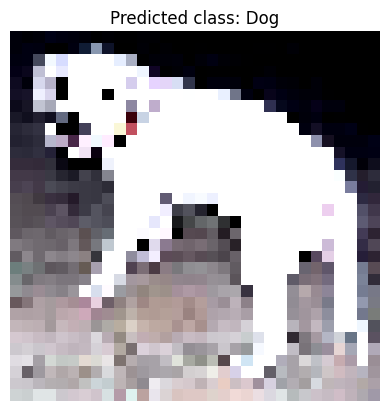

In [ ]:
image_path = ['/content/drive/MyDrive/Cifar/dr1.jpg', '/content/drive/MyDrive/Cifar/dg.jpeg']

for i in image_path:
  # Call the custom prediction function
  custom_cifar10_prediction(i)